In [ ]:
import numpy as np
import torch
from torch import nn

Dropout слой 
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

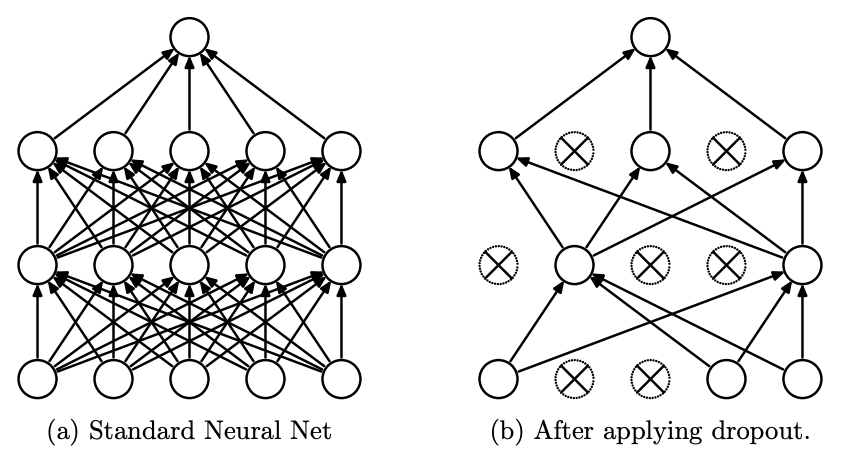

In [ ]:
class InputEmbeddings(nn.Module):
    """
    d_model : Dimension of the model (dimension of the vector)
    vocab_size: Number of words in the vocabulary
    """

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        # Using pytorch
        self.embedding = nn.Embedding(vocab_size, d_model)

    # 3.4 from the paper - we need to multiply
    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model)

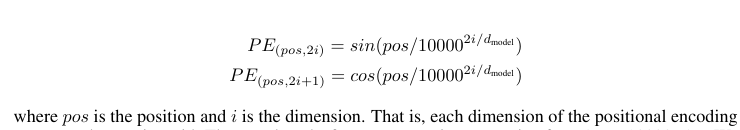

In [ ]:
class PositionalEncoding(nn.Module):
    """
    seq_len - maximum length of the sentence
    """

    def __init__(self, d_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        # matrix
        pe = torch.zeros(seq_len, d_model)

        # from the paper, but more numerical stable

        pos = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)  # (seq_len, 1)

        # another formula
        denom = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )

        # sine cosine
        pe[:, 0::2] = torch.sin(pos * denom)
        pe[:, 1::2] = torch.cos(pos * denom)

        pe = pe.unsqueeze(0)  # zero dimension, (1, seq_len, d_model)

        # saving in a file with model parameters
        self.register_buffer("pe", pe)

    def forward(self, x):
        x += (self.pe[:, : x.shape[1], :]).requres_grad_(False)  # not learned
        return self.dropout(x)

https://arxiv.org/pdf/1607.06450



In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 10**-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1))  # mult
        self.bias = nn.Parameter(torch.zeros(1))  # add

    def forward(self, x):
        mean = x.mean(
            dim=-1, keepdim=True
        )  # (mean for d_model from (batch_size, seq_len, d_model))
        std = x.std(dim=-1, keepdim=True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

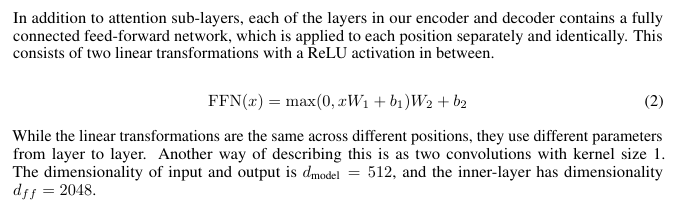

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        return self.linear.forward(x)

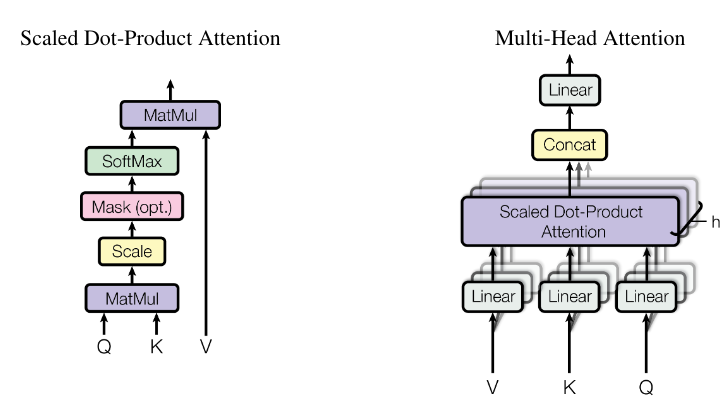

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    h - number of heads
    """

    def __init__(self, d_model: int, h: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h

        self.WQ = nn.Linear(d_model, d_model)  # learnable parameters
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

        self.WO = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def QKVAttention(query, key, value, mask, dropout: nn.Dropout):
        """
        Query : given sentence that we focused on (decoder)
        Key : every sentence to check relationship with Qeury(encoder)
        Value : every sentence same with Key (encoder)
        """
        d_k = query.shape[-1]

        attention_scores = query @ key.transpose(-2, -2) / np.sqrt(d_k)

        if mask is not None:
            attention_scores.masked_fill(mask == 0, -1e9)  # softmax(-1e9) = 0

        attention_scores = attention_scores.softmax(dim=-1)  # softmax по seq_len
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (
            attention_scores @ value
        ), attention_scores  # one for model, one for interptetability

    def forward(self, q, k, v, mask):
        # q has dimension (Batch, seq_len, d_model)
        query = self.WQ(q)  # (seq)
        key = self.WK(k)
        value = self.WV(v)

        # размерность будет (batch, seq_len, h, d_k), разделили эмбеддинг на части
        # -> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(
            1, 2
        )
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(
            1, 2
        )

        x, self.attention_scores = MultiHeadAttention.QKVAttention(
            query, key, value, mask, self.dropout
        )

        # Before transpose: (Batch size,Seq len,h,dk)
        # After transpose: (Batch size,h,Seq len,dk)
        x = x.transpose(1, 2).contigious().view(x.shape[0], -1, self.h * self.d_k)
        # concat

        # .contiguous()

        # Ensures the memory layout of the tensor is contiguous after the transpose operation.
        # This is often required before reshaping (view) the tensor.

        return self.WO(x)

In [ ]:
class SkipConnection(nn.Module):
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = nn.dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

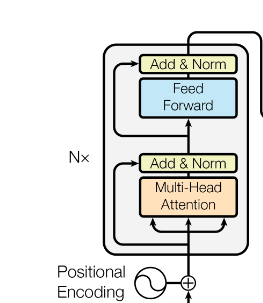

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(
        self,
        self_attention_block: MultiHeadAttention,
        feed_forward_block: FeedForward,
        dropout: float,
    ):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList(
            [SkipConnection(dropout), SkipConnection(dropout)]
        )

    def forward(self, x, src_mask):
        # Mask for self-attention to prevent attending to certain tokens (e.g., padding or future tokens in specific contexts).
        x = self.residual_connections[0](
            x, lambda y: self.self_attention_block(y, y, y, src_mask)
        )
        x = self.residual_connections[1](x, self.feed_forward_block(x))
        return x


class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

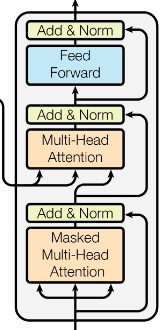

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        self_attention_block: MultiHeadAttention,
        cross_attention_block: MultiHeadAttention,
        feed_forward_block: FeedForward,
        dropout: float,
    ):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.res_connections = nn.ModuleList(
            [SkipConnection(dropout), SkipConnection(dropout), SkipConnection(dropout)]
        )

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # src_mask: Mask for the source sequence (to ignore padding tokens).
        # tgt_mask: Mask for the target sequence (causal masking).
        x = self.res_connections[0](
            x, lambda y: self.self_attention_block(y, y, y, tgt_mask)
        )
        x = self.res_connections[1](
            x,
            lambda y: self.cross_attention_block(
                y, encoder_output, encoder_output, src_mask
            ),
        )
        x = self.res_connections[2](x, self.feed_forward_block)
        return x


class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

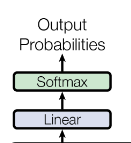

In [ ]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim=-1)

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        src_embed: InputEmbeddings,
        tgt_embed: InputEmbeddings,
        src_pos: PositionalEncoding,
        tgt_pos: PositionalEncoding,
        projection_layer: ProjectionLayer,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.encoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        return self.projection_layer(x)


def build_transformer(
    src_vocab_size: int,
    tgt_vocab_size: int,
    src_seq_len: int,
    tgt_seq_len: int,
    d_model=512,
    N: int = 6,
    h: int = 8,
    dropout: float = 0.1,
    d_ff: int = 2048,
) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForward(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(
            d_model, encoder_self_attention_block, feed_forward_block, dropout
        )
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForward(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(
            d_model,
            decoder_self_attention_block,
            decoder_cross_attention_block,
            feed_forward_block,
            dropout,
        )
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the transformer
    transformer = Transformer(
        encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer
    )

    # nn.init
    # All the functions in this module are intended to be used to initialize neural network parameters,
    # so they all run in torch.no_grad() mode and will not be taken into account by autograd.

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.uniform_(p)

    return transformer